In [95]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [100]:
def get_cone_2d_location(bin_im):
    row_sum = np.sum(bin_im, axis=1)
    i = 0

    while row_sum[i] > 1 and i < 799:
        bin_im[i, :] = np.zeros(848)
        i += 1

    airrow = 0
    for row_idx in range(799):
        if row_sum[row_idx] > 400 * 255:
            airrow = row_idx
    bin_im[1:airrow, :] = 0
    row_sum = np.sum(bin_im, axis=1)
    cone_found = False
    cone_row = 0
    max_row = 0
    row = 799  # start where no drone parts are visible in image
    cone_started = False
    while not cone_found and row >= 0:
        if row_sum[row] >= max_row and row_sum[row] > 4 * 255:
            cone_row = row
            max_row = row_sum[row]
            cone_started = True
        elif cone_started:
            cone_found = True
        row -= 1

    current_start = 0
    max_start = 0
    max_width = 0
    current_width = 0
    for col_index in range(847):
        if bin_im[cone_row, col_index] == 0:
            if current_width > max_width:
                max_width = current_width
                max_start = current_start
            current_width = 0
            current_start = 0
        else:
            if current_width == 0:
                current_start = col_index
            current_width += 1
    if current_width>max_width:
        max_width = current_width
        max_start = current_start
            
    return [max_start + int(np.ceil(max_width / 2)) - 424, -cone_row + 400, max_width]

In [101]:
def get_cone_3d_location(cone_width_px, cone_width_m, conetop_coor, tune_factor):
    x_cor = 0
    y_cor = 0
    z_cor = -1  # do not update if z remains -1 TODO
    if cone_width_px > 0:  # only updates when cone detected
        # position relative to the camera in meters.
        z_cor = cone_width_m * tune_factor / cone_width_px
        x_cor = conetop_coor[0] * z_cor / tune_factor
        y_cor = conetop_coor[1] * z_cor / tune_factor
    return np.array([z_cor, -x_cor, y_cor])

In [153]:
def noise_creation(image,amount):
    [width,height] = image.shape
    for i in range(amount):
        x = int(np.random.rand()*width)
        y = int(np.random.rand()*height)
        image[x,y] = 1
    return image

9
19
29
35
36
46
81
84
132
140
162
165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


188
198
[ 2.8125   0.05625 -1.94625]
[ 2.55134  0.13495 -2.18995]
199
fps_average: 271.9848363556544
average error x: 0.6778013499999996m
average error y: 0.64066295m
average error z: 1.3405414499999995m
error bias: 0.5748617556428665 dependant on distance: 0.055921510154245846


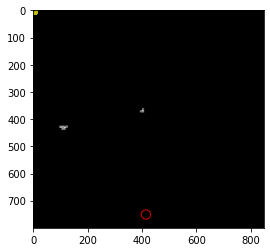

In [167]:
#TEST 1 normal 
text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted/data_collection_gazebo/raw_data/21-05-12_12-05-55/action.data'
image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted/data_collection_gazebo/raw_data/21-05-12_12-05-55/observation/'
outliers_1 = [9,19,29,35,36,46,81,84,132,140,162,165,188,199,198]

#Test 2 single cone
#text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_single_cone/data_collection_gazebo/raw_data/21-05-12_20-28-33/action.data'
#image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_single_cone/data_collection_gazebo/raw_data/21-05-12_20-28-33/observation/'
#outliers_2 = [1,22,65,108,124,150,162,172,178]

#Test 3 30cones

#text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_30_cone/data_collection_gazebo/raw_data/21-05-12_20-54-01/action.data'
image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_30_cone/data_collection_gazebo/raw_data/21-05-12_20-54-01/observation/'
error_x = []
nb_images = 200
tune_factor = 500
total_error_x = 0
total_error_y = 0
total_error_z = 0
distance_x = []
total_time = 0
with open(text_file_path) as f:
    for image_idx in range(nb_images):
        ground_truth = f.readline().split()[2:5]
        ground_truth_np = np.array([float(ground_truth[0]),float(ground_truth[1]),float(ground_truth[2])])
        
        #print(ground_truth_np)
        image_path = image_base_path+str(image_idx).zfill(15)+'.jpg'
        image = cv2.imread(image_path,-1)
        #image_pr = noise_creation(image,5000)
        #image_pr = image
        #plt.imshow(image,cmap='gray',vmax=255,vmin=0)
        time_start = time.time()
        image_coord = get_cone_2d_location(image_pr)
        world_coor = get_cone_3d_location(image_coord[2],0.18,image_coord[0:2],tune_factor)
        total_time +=(time.time()-time_start)
        #print(world_coor)
        current_error = abs(np.subtract(world_coor[0],ground_truth_np[0]))
        #if current_error>1:
        #    print(image_idx)
            #print(current_error)
            #print(world_coor)
            #print(ground_truth_np)
        if image_idx in outliers_1:
            print(image_idx)
        else:
            total_error_x += abs(np.subtract(world_coor[0],ground_truth_np[0]))
            total_error_y += abs(np.subtract(world_coor[1],ground_truth_np[1]))
            total_error_z += abs(np.subtract(world_coor[2],ground_truth_np[2]))
            distance_x.append(ground_truth_np[0])
            error_x.append(current_error)
        total_error += current_error
        if image_idx == 198:
            #print('image 84:')
            #print(current_error)
            print(world_coor)
            print(ground_truth_np)
            prop_image = np.zeros((800,848,3))
            prop_image[:,:,0] = image
            prop_image[:,:,1] = image
            prop_image[:,:,2] = image
            np_pred = world_coor
            scaling_factor = 1
            x_position = int(-np_pred[1] / np_pred[0] * 505.3/scaling_factor + 424.5/scaling_factor)
            y_position = int(-np_pred[2] / np_pred[0] * 505.3/scaling_factor + 400.5/scaling_factor)
            cv2.circle(prop_image, (x_position,y_position), int(50/np_pred[0]/scaling_factor), (255,0,0), 2)
            plt.imshow(prop_image)
        #print(error)
print('fps_average: '+ str(nb_images/(total_time)))
gradient,intercept = np.polyfit(distance_x,error_x,1)
x1=np.linspace(1,5,500)
y1=gradient*x1+intercept
plt.plot(distance_x,error_x,'yo', x1, y1, '--k')
average_error_x = total_error_x/nb_images
average_error_y = total_error_y/nb_images
average_error_z = total_error_z/nb_images
print('average error x: '+str(average_error_x)+'m')
print('average error y: '+str(average_error_y)+'m')
print('average error z: '+str(average_error_z)+'m')
print('error bias: '+str(intercept) +' dependant on distance: '+ str(gradient))